---
# <span style="color:blue">**Data Exploration and PCA**</span>
---

---
### **Load data and features**
---

In [1]:
import functions as fn

X_tr, y_tr, y_tr_labels, train_features, train_filenames = fn.load_data('trainfile_mobile_v2.npz', 'Training')
X_val, y_val, y_val_labels, val_features, val_filenames = fn.load_data('validfile_mobile_v2.npz', 'Validation')
X_te, y_te, y_te_labels, test_features, te_filenames = fn.load_data('testfile_mobile_v2.npz', 'Test')

Training data info:
-------------------
X: (280, 224, 224, 3)
y: (280, 6)
labels: (6,)
features: (280, 1280)
filenames (280,) 

Validation data info:
---------------------
X: (139, 224, 224, 3)
y: (139, 6)
labels: (6,)
features: (139, 1280)
filenames (139,) 

Test data info:
---------------
X: (50, 224, 224, 3)
y: (50, 6)
labels: (6,)
features: (50, 1280)
filenames (50,) 



---
### **Plot the number of images per category**
---

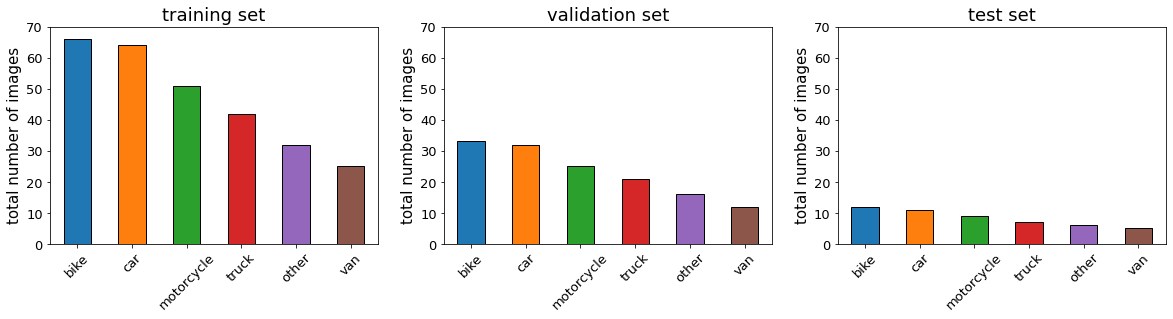

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to return the values count per category
def samples_per_category(y, labels):
    df = pd.DataFrame(y, columns=labels)
    df['cat'] = (df.iloc[:, :] == 1).idxmax(1)
    
    return df.cat.value_counts()


# Get samples per category
tr_data = samples_per_category(y_tr, y_tr_labels)
te_data = samples_per_category(y_te, y_te_labels)
val_data = samples_per_category(y_val, y_val_labels)

# Define dictionary for set
set_name = {0: 'training', 1: 'validation', 2: 'test'}

# Define suplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

# Define colors to be used
cmap = plt.cm.tab10
colors = cmap(np.arange(6))

# Plot
for i, ax in enumerate(axes):
    
    if set_name[i]=='training':
        tr_data.plot.bar(edgecolor='black', color=colors, ax=ax)
    elif set_name[i]=='validation':
        val_data.plot.bar(edgecolor='black', color=colors, ax=ax)
    else:
        te_data.plot.bar(edgecolor='black', color=colors, ax=ax)
    
    ax.set_title(set_name[i]+' set', fontsize=18)    
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylabel('total number of images', fontsize=15)
    ax.set_ylim(0,70)

---
    From the above plot we see an unbalanced amount of images per category in all three sets. 
---

---
### **Plot some images per category**
---

 Training set - Sample images from different categories 


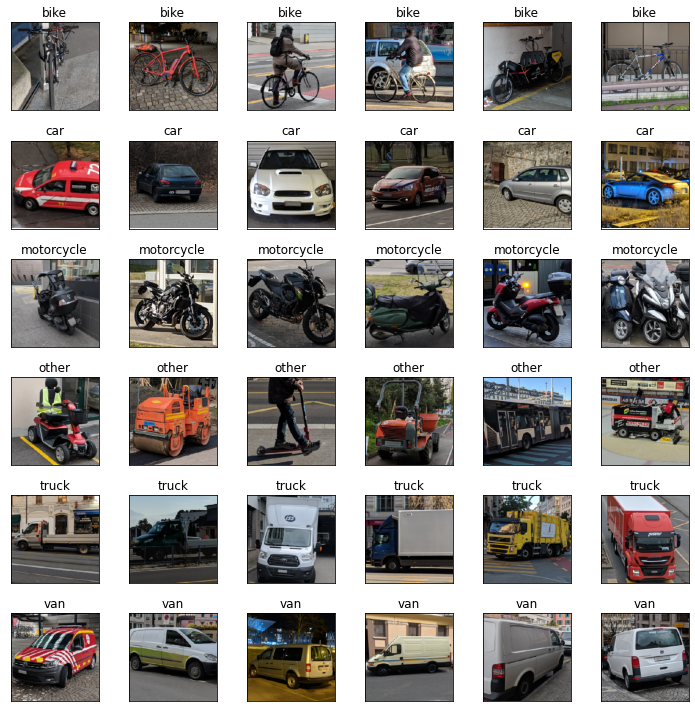

In [3]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(10, 10))
axes = axes.flatten()

n_col = 0 # var to be always in the range 0-6
cnt_zeros = 0 # var to count how many times the i iterator below when divided by 6 gave a modulo of zero
idx = 0 # index to go to a different category of images

print('\033[1m Training set - Sample images from different categories \033[0m')
for i, axis in enumerate(axes):  
    
    # Check modulo of i when divided by 6
    if (i%6==0):
        n_col=0 # reset n_col to zero
        cnt_zeros+=1 # start counting how many times the modulo returned 0
    else:
        n_col+=1 # increase n_col by 1
    
    if ((i%6==0) & (cnt_zeros!=1)): # shift the idx to the next category of images
        idx+=tr_data[cnt_zeros-2]
    
    # Variable to hold the real index to retrieve images and labels
    real_index = idx+n_col
    
    # Get index of labels
    idx_label = np.where(y_tr[real_index] == 1)[0]
        
    # Find label
    label = y_tr_labels[idx_label[0]]
    
    # Plot images
    axis.imshow(X_tr[real_index])
    axis.set_title(label)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis    

plt.tight_layout()    
plt.show()

---
### **PCA exploration**
---

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create PCA transformer
pca = PCA(n_components=None)

# Apply PCA on training features
pca.fit(train_features)

# Proportion of variance explained
pve = pca.explained_variance_ratio_

In [5]:
print('PCA n_samples:', pca.n_samples_)
print('PCA n_features:', pca.n_features_)
print('PCA n_components:', pca.n_components_)

PCA n_samples: 280
PCA n_features: 1280
PCA n_components: 280


---
    Since the number of samples is very small with respect to the number of features the total PCA components have the same size as the number of samples
---

#### **Scree plot**
---

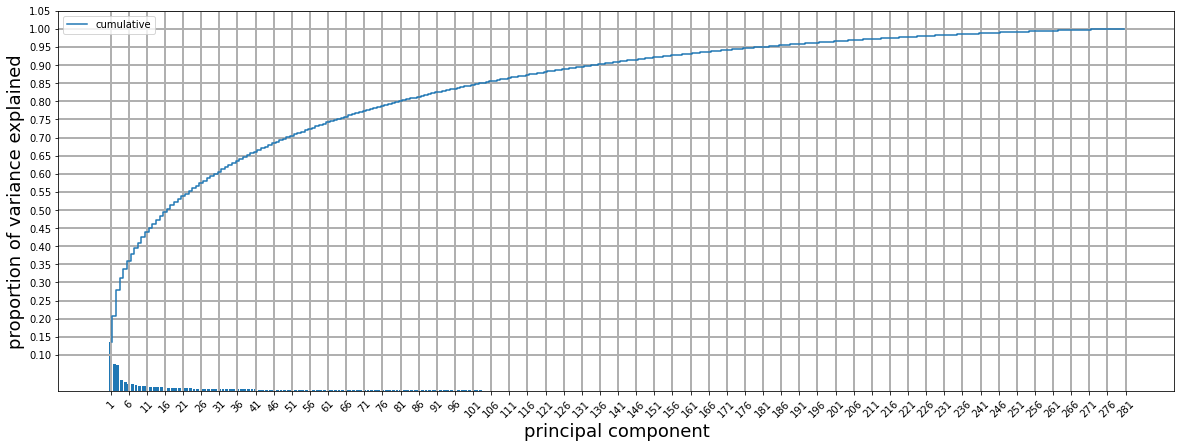

In [6]:
plt.figure(figsize=(20, 7))

# Create bar plot
xcor = np.arange(1, len(pve) + 1) # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor)

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5, # 1.5,2.5,..,n_components+0.5
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

# Add labels
plt.xlabel('principal component', fontsize=18)
plt.ylabel('proportion of variance explained', fontsize=18)
plt.xticks(np.arange(1, pca.n_components_+5, 5), rotation=45)
plt.yticks(np.arange(0.1, 1.1, 0.05))
plt.legend()
plt.grid(linewidth = 2)
plt.show()

In [7]:
pve_cumsum_df = pd.DataFrame(pve_cumsum, columns=['PVE'])
pve_cumsum_df['n_components'] = np.arange(pve_cumsum_df.shape[0])+1
pve_cumsum_df=pve_cumsum_df.reindex(columns=['n_components','PVE'])
pve_cumsum_df['PVE_ratio'] = np.floor(np.round(pve_cumsum_df['PVE']*10))
pve_cumsum_df.loc[pve_cumsum_df.iloc[:, 2].shift(1) != pve_cumsum_df.iloc[:, 2]]

,n_components,PVE,PVE_ratio
0,1,0.134494,1.0
1,2,0.208749,2.0
2,3,0.279986,3.0
5,6,0.358333,4.0
11,12,0.450551,5.0
22,23,0.552492,6.0
38,39,0.651370,7.0
63,64,0.751432,8.0
103,104,0.851206,9.0
180,181,0.950296,10.0


---
> * 1 PCA component explains 10% of the variance
> * 2 PCA components explain 20% of the variance
> * 3 PCA components explain 30% of the variance
> * 7 PCA components explain 40% of the variance
> * 16 PCA components explain 50% of the variance
> * 30 PCA components explain 60% of the variance
> * 50 PCA components explain 70% of the variance
> * 81 PCA components explain 80% of the variance
> * 135 PCA components explain 90% of the variance
> * 260 PCA components explain 100% of the variance
---

#### **2D plot of first two components**
---

In [8]:
# create a new nd array with the indices
y_tr_indices = np.where(y_tr == 1)[1] 

# transform train features
train_features_2d = pca.transform(train_features)

# Check shape; shoulb be (280,280)
print('Size of trained features after PCA transformation:',train_features_2d.shape)

Size of trained features after PCA transformation: (280, 280)


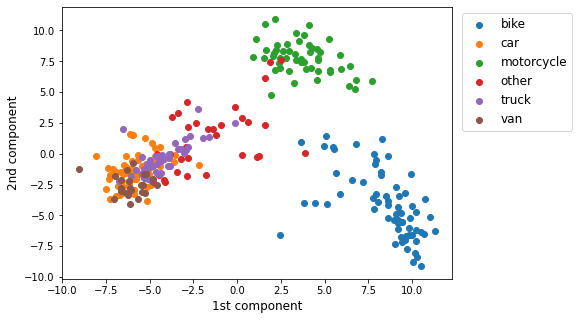

In [9]:
fig = plt.figure(figsize=(7, 5))

# Plot each category
for cat in [0, 1, 2, 3, 4, 5]:

    idx = (y_tr_indices == cat)
    
    # Plot their first two pca components
    plt.scatter(
        train_features_2d[idx, 0], train_features_2d[idx, 1],
        label=y_tr_labels[cat]
    )

# Labels and legend
plt.xlabel('1st component', fontsize=12)
plt.ylabel('2nd component', fontsize=12)
plt.legend(bbox_to_anchor=(1.01,1), fontsize=12)
plt.show()


---
    The bike and motorcycle images occupy a different region in the new feature space. The rest of the categories seem to overlap among them especially the car, van and truck while the category other has also few data points close to the motorcycle and the bike categories.
---